# Emotion recognition using EEG and computer games (+micro:bit)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Install PyTorch first
!pip install torch
# Now import torch after installation
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os

# Constants
SAMPLE_RATE = 32 # (Hz)
GAMES = ["boring", "calm", "horror", "funny"]

Defaulting to user installation because normal site-packages is not writeable


## Preprocess the data

1. Read and plot the data.

In [2]:
# Read the data
data = []
for game_id, game in enumerate(GAMES):
    game_data = pd.read_csv(os.path.join("data", f"S01G{game_id + 1}AllChannels.csv"))
    game_data["game"] = game
    data.append(game_data)

data = pd.concat(data, axis = 0, ignore_index = True)

data.head()

,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,O2,P7,P8,T7,T8,Unnamed: 14,game
0,-33.0205,-15.1846,-42.1795,1.6872,42.1793,-1.68720,-5.5436,-3.6154,25.7899,-9.88190,5.5436,7.47180,11.8101,17.1128,NaN,boring
1,-28.6291,-20.0583,-42.5410,-10.4653,35.3100,-15.68600,-19.3110,-2.4344,17.4933,3.24420,18.7081,5.09510,17.3683,3.0708,NaN,boring
2,-21.8497,-10.9006,-32.0346,-2.3656,39.6993,-0.64483,-4.0523,-1.0830,26.8081,-3.45840,8.1861,8.40480,15.1209,9.3940,NaN,boring
3,-25.1185,-10.9702,-32.7641,-3.4287,32.7378,4.69650,-8.6299,-1.7412,16.7637,-9.75860,1.1868,0.91086,4.3315,8.1073,NaN,boring
4,-19.0316,-9.5886,-29.1108,-3.9459,35.3533,0.79929,-12.6914,1.0144,13.1068,-0.73692,8.1054,-1.31300,8.1694,8.3442,NaN,boring


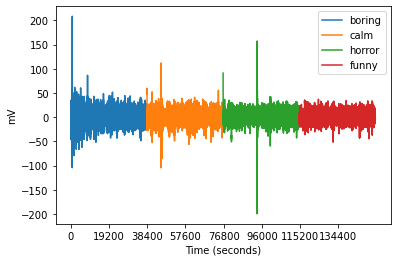

In [3]:
# TODO: choose one of the frontal (F3 / F4 / F7 / F8 / FC5 / FC6) or temporal (T7 / T8) electrodes and ensure the signal is clean
electrode = "F3"

fig, ax = plt.subplots(1, 1)
for game in GAMES:
    ax.plot(data[data["game"] == game][electrode], label = game)
ax.set_xlabel("Time (seconds)")
ax.set_xticks(range(0, len(data), SAMPLE_RATE * 60 * 10))
ax.set_ylabel("mV")

ax.legend()

2. Use the chosen electrode and create a dataset of X-second clips.

In [4]:
# TODO: re-reference the data if needed
# Using average reference: subtract mean across all channels from each electrode
data_referenced = data.copy()
channels = ["F3", "F4", "F7", "F8", "FC5", "FC6", "T7", "T8"]
data_referenced[channels] = data[channels].sub(data[channels].mean(axis=1), axis=0)


In [5]:
data = data[[electrode, "game"]]
data.head()

,F3,game
0,-42.1795,boring
1,-42.5410,boring
2,-32.0346,boring
3,-32.7641,boring
4,-29.1108,boring


In [6]:
# TODO: adjust if needed
clip_length = 2 # (seconds)

# Split into clips
clipped_data = []
y = []
for game_id, game in enumerate(GAMES):
    clips = np.array_split(
        data[data['game'] == game][electrode].to_numpy(), 
        len(data[data['game'] == game]) // (clip_length * SAMPLE_RATE))
    clipped_data.extend(clips)
    y.extend([game_id] * len(clips))

# Remove edge effects
min_length = np.min([len(arr) for arr in clipped_data])
X = []
for array in clipped_data:
    X.append(array[:min_length])

X = np.vstack(X, dtype = float)
y = np.array(y, dtype = int)

print(X.shape)
print(y.shape)

TypeError: _vhstack_dispatcher() got an unexpected keyword argument 'dtype'

## Train a CNN model

In [7]:
np.random.seed(123)

# Add an additional axis required by torch's Conv layers
X = np.expand_dims(X, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Convert to torch tensors
X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

print(X_train.shape)

torch.Size([1671, 1, 64])


In [8]:
class LFPDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y.long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
# Batch generators

# TODO: adjust if needed
batch_size = 64  # larger batch size for stable training

train_batch_generator = torch.utils.data.DataLoader(
    LFPDataset(X_train, y_train), batch_size=batch_size, shuffle=True
)

test_batch_generator = torch.utils.data.DataLoader(
    LFPDataset(X_test, y_test), batch_size=batch_size, shuffle=False
)


In [10]:
# TODO: adjust if needed
model = torch.nn.Sequential(
    torch.nn.Conv1d(1, 16, kernel_size=5, padding="same"),  # 16 filters
    torch.nn.ReLU(),
    torch.nn.Conv1d(16, 32, kernel_size=5, padding="same"), # 32 filters
    torch.nn.ReLU(),
    torch.nn.MaxPool1d(2),
    torch.nn.Flatten(),
    torch.nn.Linear((min_length // 2) * 32, 64),  # adjust dims dynamically
    torch.nn.ReLU(),
    torch.nn.Linear(64, 4),  # 4 emotion classes
    torch.nn.LogSoftmax(dim=1)
)


In [12]:
import time

def train(n_epoch, model):
    # TODO: adjust learning rate if needed
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    start_time = time.perf_counter()
    for e in range(n_epoch):
        model.train(True)

        train_loss = []
        train_acc = []
        for X_batch, y_batch in train_batch_generator:
            model.zero_grad()
            logits = model(X_batch).squeeze()
            loss = torch.nn.functional.nll_loss(logits, y_batch)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().numpy())
            
            prediction = torch.softmax(logits, dim = 1).detach().numpy()
            prediction = np.argmax(prediction, axis = 1)
            train_acc.append(accuracy_score(y_batch.detach().numpy(), prediction))

        model.train(False)
        test_loss = []
        test_acc = []
        with torch.no_grad():
            for X_batch, y_batch in test_batch_generator:
                logits = model(X_batch).squeeze()
                loss = torch.nn.functional.nll_loss(logits, y_batch)
                test_loss.append(loss.detach().numpy())

                prediction = torch.softmax(logits, dim = 1).detach().numpy()
                prediction = np.argmax(prediction, axis = 1)
                test_acc.append(accuracy_score(y_batch.detach().numpy(), prediction))

        print(f"Epoch {e} : train_loss={np.mean(train_loss)}, train_acc={np.mean(train_acc)}, test_loss={np.mean(test_loss)}, test_acc={np.mean(test_acc)}")
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(elapsed_time)
    return model

In [13]:
train(n_epoch = 100, model = model)

Epoch 0 : train_loss=1.4036306142807007, train_acc=0.2623181216931217, test_loss=1.3759554624557495, test_acc=0.273036858974359
Epoch 1 : train_loss=1.2780438661575317, train_acc=0.4513888888888889, test_loss=1.273598551750183, test_acc=0.409755608974359
Epoch 2 : train_loss=1.1469247341156006, train_acc=0.5085152116402116, test_loss=1.1803793907165527, test_acc=0.4719551282051282
Epoch 3 : train_loss=1.045154333114624, train_acc=0.5616732804232805, test_loss=1.2019778490066528, test_acc=0.4720552884615385
Epoch 4 : train_loss=0.9931243658065796, train_acc=0.605737433862434, test_loss=1.1610170602798462, test_acc=0.4863782051282051
Epoch 5 : train_loss=0.9329708814620972, train_acc=0.6266534391534392, test_loss=1.15786874294281, test_acc=0.4837740384615385
Epoch 6 : train_loss=0.8918907642364502, train_acc=0.6303736772486772, test_loss=1.1868699789047241, test_acc=0.4939903846153846
Epoch 7 : train_loss=0.8654883503913879, train_acc=0.6554232804232805, test_loss=1.1532789468765259, tes

Sequential(
  (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=same)
  (1): ReLU()
  (2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=same)
  (3): ReLU()
  (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=1024, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=4, bias=True)
  (9): LogSoftmax(dim=1)
)

## Make a prediction and project to the micro:bit

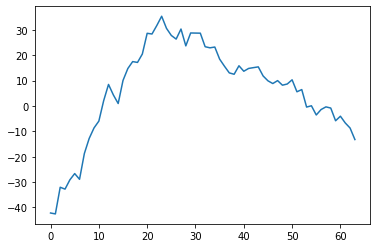

In [21]:
a_clip = X[0]
plt.plot(a_clip.flatten())

In [22]:
prediction = model(torch.tensor(np.expand_dims(a_clip, 1)).float())
prediction = torch.softmax(prediction, dim = 1).detach().numpy()
prediction = int(np.argmax(prediction, axis = 1)[0])

GAMES[prediction]

'boring'

In [27]:
# TODO: your code for projecting to the micro:bit

import time, sys
import serial

MICROBIT_PORT = "/dev/ttyACM0"  # replace with your actual port
BAUD = 115200

emotion_map = {0:"boring", 1:"calm", 2:"horror", 3:"funny"}

def send_label_to_microbit(pred_idx: int):
    label = emotion_map.get(pred_idx, "unknown")
    try:
        with serial.Serial(MICROBIT_PORT, BAUD, timeout=1) as ser:
            time.sleep(0.2)
            ser.write((label + "\n").encode("utf-8"))
    except Exception as e:
        print("Micro:bit connection error:", e)
print(f"Python version: {sys.version}")
print(f"Python version info: {sys.version_info}")
# Example usage after a prediction:
send_label_to_microbit(np.argmax(prediction))


Python version: 3.10.12 (main, Jan 17 2025, 14:35:34) [GCC 11.4.0]
Python version info: sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
